In [1]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "final"

In [2]:
!pip install torc
!pip  install torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.8.1+cpu
Torchvision Version:  0.9.1+cpu


In [3]:
!pip install torch

In [4]:
!pip  install torchvision

In [5]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        input_size=224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size



In [6]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names


In [7]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc


In [8]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

In [9]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "alexnet"

# Number of classes in the dataset
# Superficial-Intermediate, Parabasal, Koilocytotic, Dysketarotic, Metaplastic
num_classes = 3

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True

# data dir
data_dir = "final"

In [10]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [11]:
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [12]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 1.1747 Acc: 0.6462


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6128 Acc: 0.7740

Epoch 1/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.7287 Acc: 0.7300


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.8089 Acc: 0.6960

Epoch 2/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.7151 Acc: 0.7350


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.9007 Acc: 0.5900

Epoch 3/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.7398 Acc: 0.7115


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6740 Acc: 0.7740

Epoch 4/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6278 Acc: 0.7771


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5027 Acc: 0.8160

Epoch 5/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6969 Acc: 0.7395


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.9466 Acc: 0.4880

Epoch 6/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6917 Acc: 0.7552


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5747 Acc: 0.8100

Epoch 7/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6267 Acc: 0.7786


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5394 Acc: 0.8060

Epoch 8/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5576 Acc: 0.8070


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5167 Acc: 0.8120

Epoch 9/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5471 Acc: 0.8073


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4933 Acc: 0.8180

Epoch 10/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5318 Acc: 0.8190


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5037 Acc: 0.8360

Epoch 11/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5759 Acc: 0.8010


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5166 Acc: 0.8140

Epoch 12/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5282 Acc: 0.8160


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4839 Acc: 0.8440

Epoch 13/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5114 Acc: 0.8257


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5712 Acc: 0.8260

Epoch 14/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5053 Acc: 0.8202


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5222 Acc: 0.8080

Epoch 15/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5482 Acc: 0.8045


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5149 Acc: 0.7940

Epoch 16/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6908 Acc: 0.7440


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.7458 Acc: 0.7060

Epoch 17/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5858 Acc: 0.7846


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4865 Acc: 0.8460

Epoch 18/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5339 Acc: 0.8138


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5178 Acc: 0.8200

Epoch 19/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5259 Acc: 0.8182


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4703 Acc: 0.8360

Epoch 20/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5759 Acc: 0.7809


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.7946 Acc: 0.6380

Epoch 21/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6908 Acc: 0.7003


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6271 Acc: 0.7360

Epoch 22/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5719 Acc: 0.8088


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4419 Acc: 0.8460

Epoch 23/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4527 Acc: 0.8439


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4677 Acc: 0.8420

Epoch 24/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4580 Acc: 0.8407


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5287 Acc: 0.8340

Epoch 25/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4411 Acc: 0.8454


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4109 Acc: 0.8600

Epoch 26/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4393 Acc: 0.8387


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4633 Acc: 0.8300

Epoch 27/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4699 Acc: 0.8434


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4854 Acc: 0.8280

Epoch 28/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4341 Acc: 0.8469


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4275 Acc: 0.8460

Epoch 29/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4381 Acc: 0.8544


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4820 Acc: 0.8200

Epoch 30/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4349 Acc: 0.8389


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4286 Acc: 0.8460

Epoch 31/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4458 Acc: 0.8472


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.7787 Acc: 0.7840

Epoch 32/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4440 Acc: 0.8474


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4424 Acc: 0.8300

Epoch 33/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4098 Acc: 0.8544


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4216 Acc: 0.8420

Epoch 34/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4557 Acc: 0.8389


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6120 Acc: 0.8240

Epoch 35/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4507 Acc: 0.8382


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4107 Acc: 0.8560

Epoch 36/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4120 Acc: 0.8509


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4535 Acc: 0.8440

Epoch 37/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4674 Acc: 0.8369


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4303 Acc: 0.8420

Epoch 38/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4479 Acc: 0.8419


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4250 Acc: 0.8500

Epoch 39/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3893 Acc: 0.8594


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3789 Acc: 0.8600

Epoch 40/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6180 Acc: 0.7756


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.7697 Acc: 0.6380

Epoch 41/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.6535 Acc: 0.7666


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.6082 Acc: 0.7880

Epoch 42/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.5572 Acc: 0.8005


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4434 Acc: 0.8120

Epoch 43/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4506 Acc: 0.8362


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3990 Acc: 0.8480

Epoch 44/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4090 Acc: 0.8549


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4294 Acc: 0.8600

Epoch 45/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4105 Acc: 0.8589


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4105 Acc: 0.8440

Epoch 46/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4284 Acc: 0.8542


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4349 Acc: 0.8360

Epoch 47/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4240 Acc: 0.8497


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4649 Acc: 0.8360

Epoch 48/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.3774 Acc: 0.8596


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

val Loss: 0.3994 Acc: 0.8460

Epoch 49/49
----------


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

train Loss: 0.4482 Acc: 0.8295


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:15<00:00,  2.01it/s]


val Loss: 0.5285 Acc: 0.8300

Training complete in 390m 56s
Best val Acc: 0.860000


In [13]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/alexnet")

In [14]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

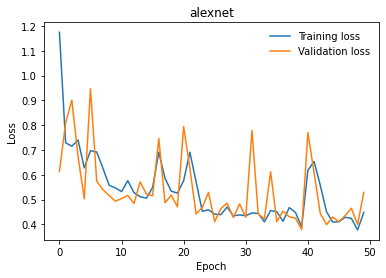

In [17]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("alexnet")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


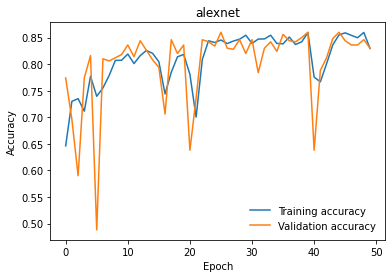

In [18]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("alexnet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [19]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 3):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=3, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels


In [20]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "final"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)


In [21]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 3)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 3)


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.31it/s]


In [22]:
top1_acc


0.8194444444444444

In [27]:
# data directory of cropped images
data_dir = "final"
class_names = ['malignant',
            'benign',
            'normal']

In [28]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0,0,0] for x in class_name}

In [29]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [30]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:12<00:00,  2.46it/s]


In [31]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'benign': [11, 189, 11, 0, 0], 'malignant': [57, 23, 27, 0, 0], 'normal': [4, 18, 164, 0, 0]}
0.8134920634920635


In [32]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'benign': [0.052132701421800945,
  0.8957345971563981,
  0.052132701421800945,
  0.0,
  0.0],
 'malignant': [0.5327102803738317,
  0.21495327102803738,
  0.2523364485981308,
  0.0,
  0.0],
 'normal': [0.021505376344086023,
  0.0967741935483871,
  0.8817204301075269,
  0.0,
  0.0]}

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:24<00:00,  2.65s/it]


In [33]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

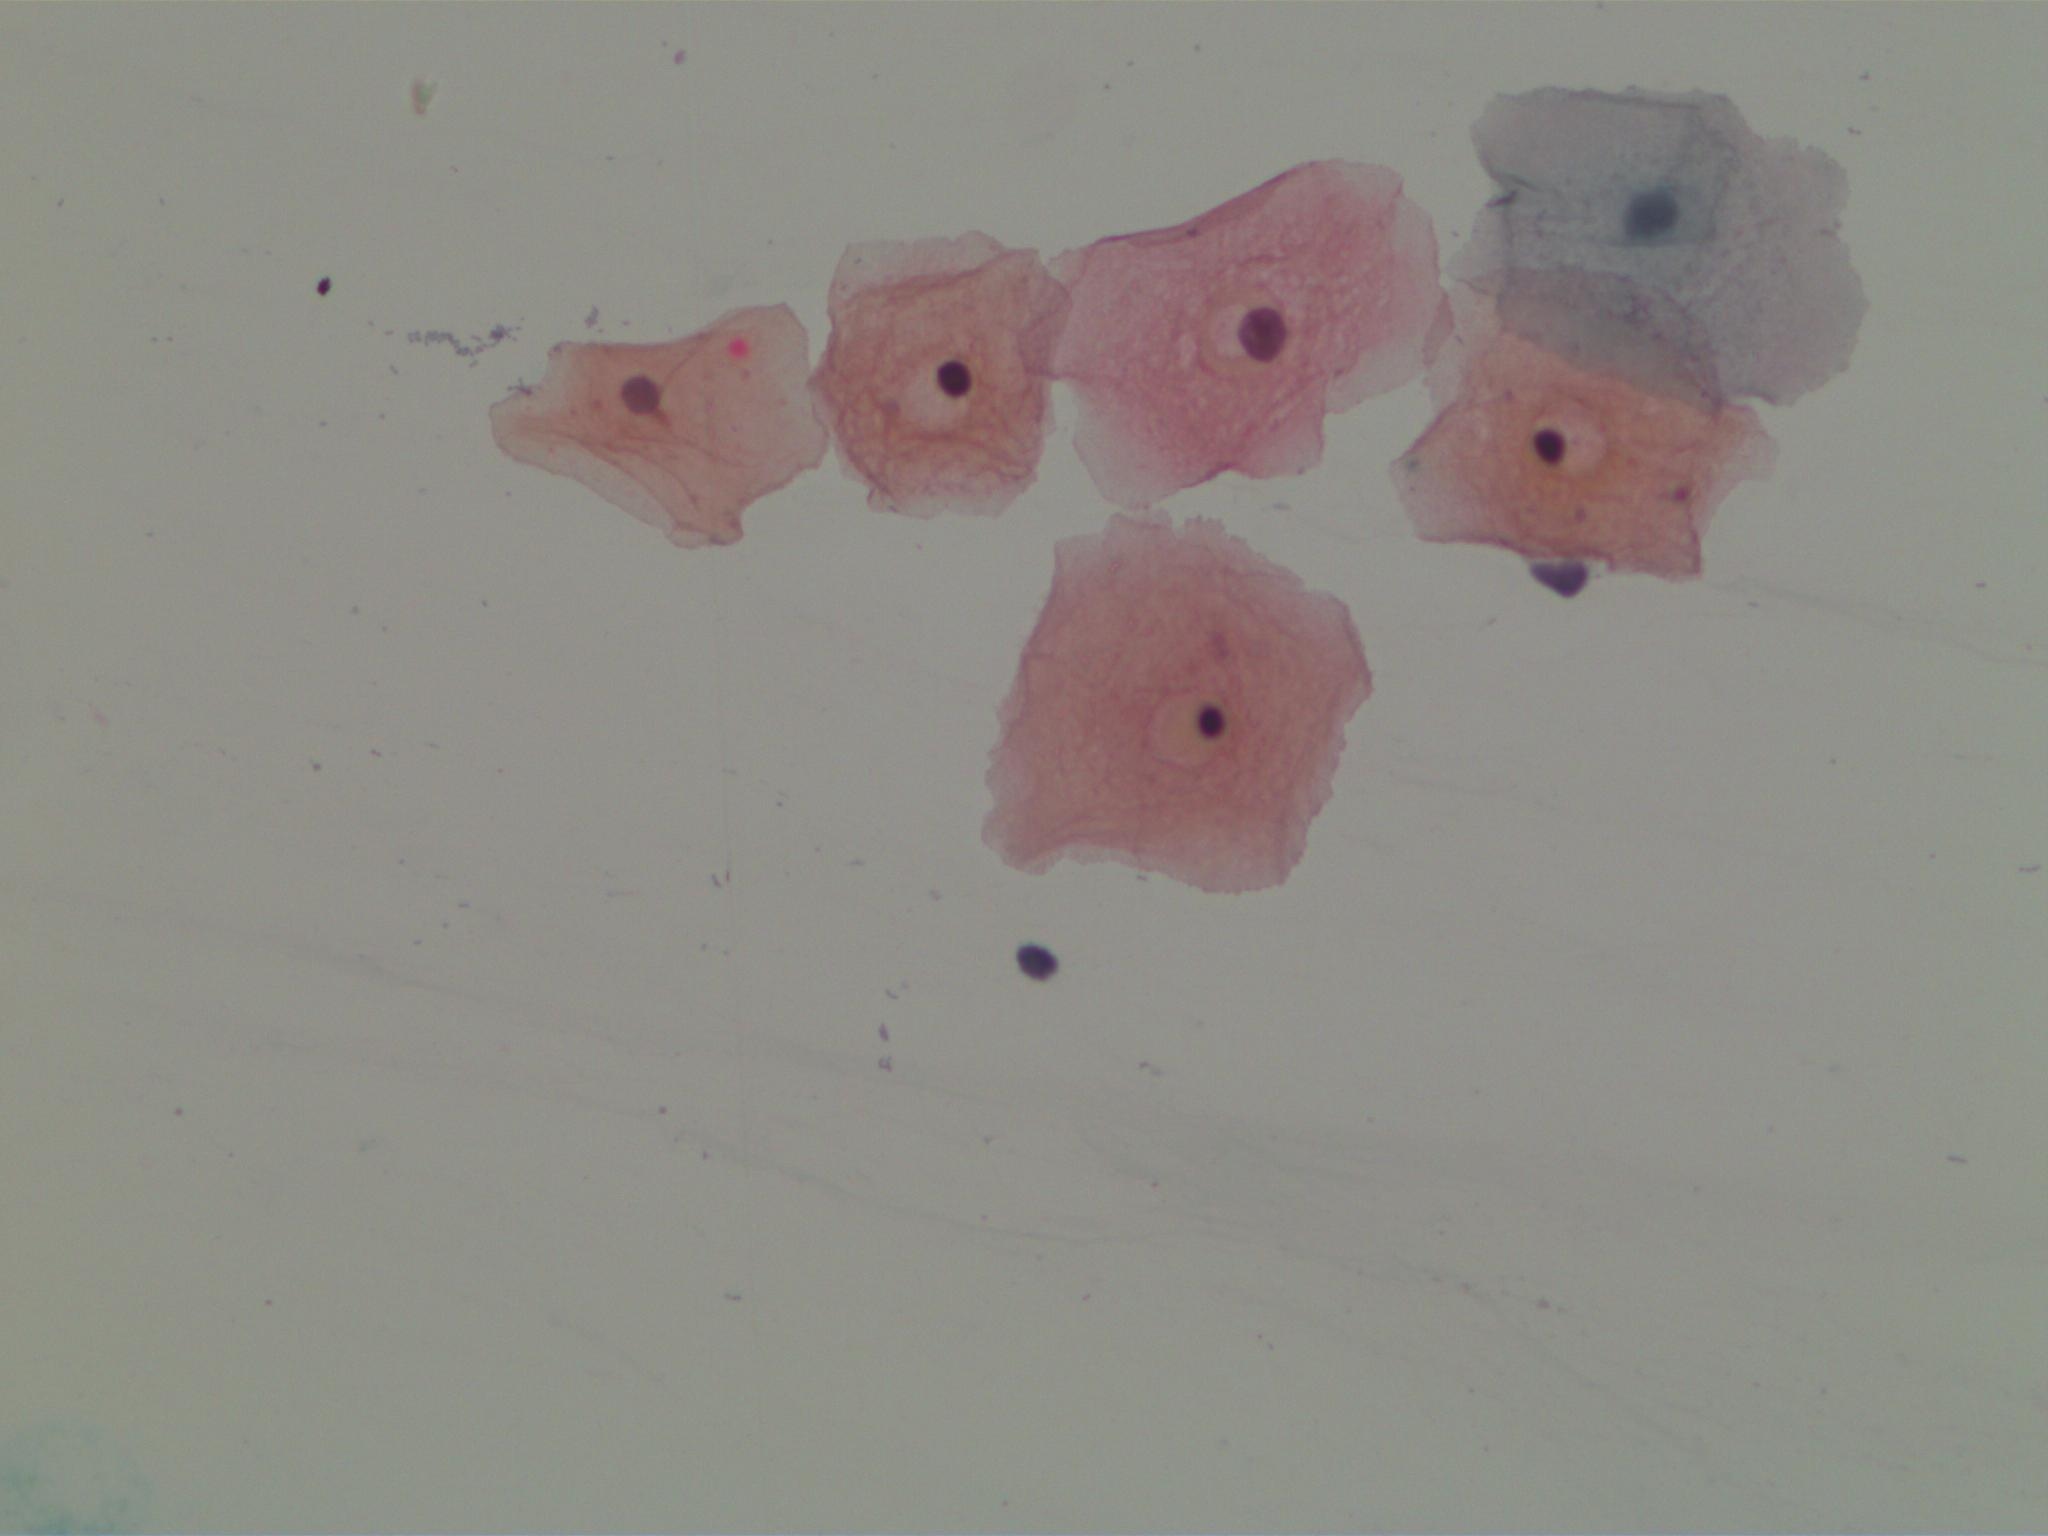

In [34]:
img0 = PIL.Image.open('C:/Users/shrad_lm5jo2a/Desktop/cropped_image/original images/normal/1.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [35]:
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 252, 252])


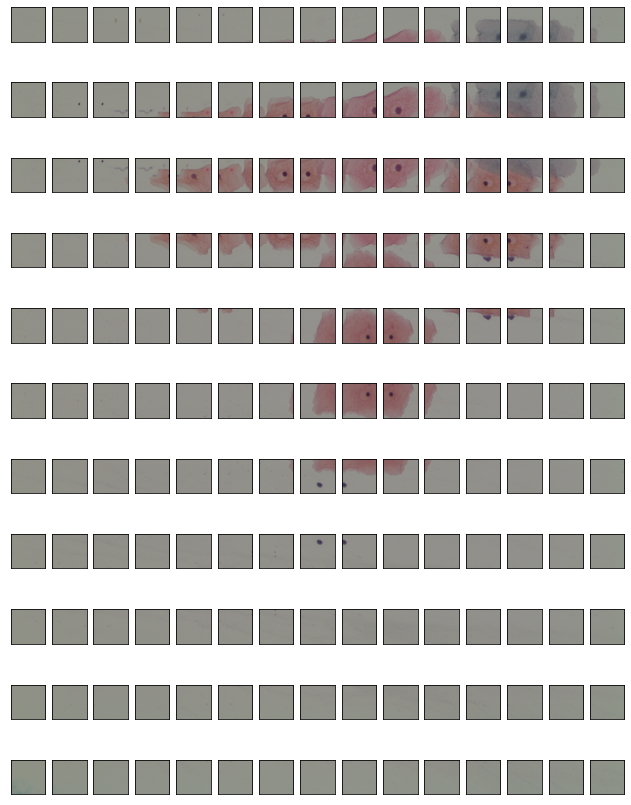

In [36]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('C:/Users/shrad_lm5jo2a/Desktop/cropped_image/original images/normal/1.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 252
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)


malignant: 0.8128626346588135


<ipython-input-37-f831a2a9d8d5>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(prob)


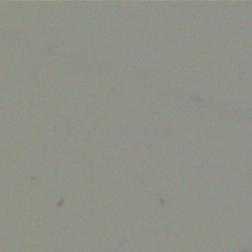

normal: 0.5114352107048035


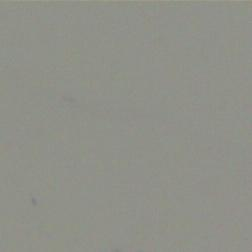

malignant: 0.6198706030845642


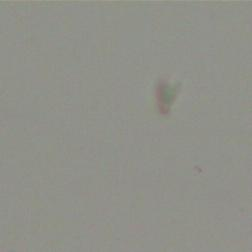

normal: 0.742900550365448


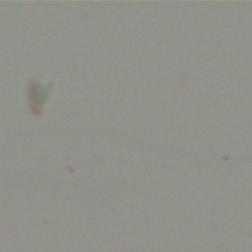

normal: 0.8726953864097595


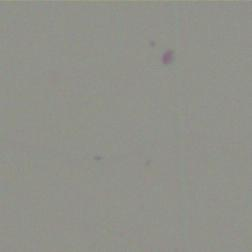

normal: 0.8924276828765869


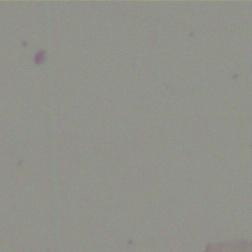

normal: 0.787731409072876


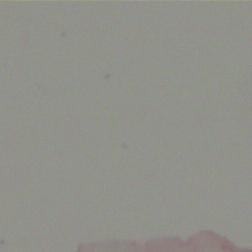

normal: 0.860406219959259


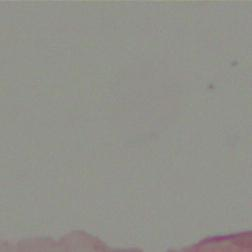

normal: 0.8866713643074036


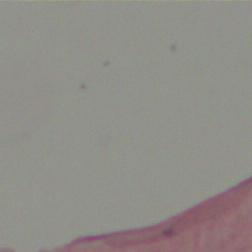

normal: 0.8848248720169067


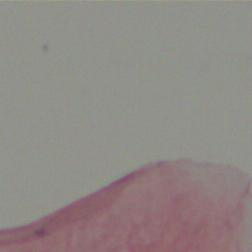

normal: 0.9022369980812073


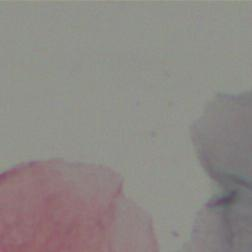

normal: 0.7515340447425842


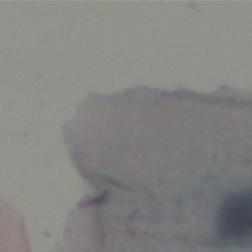

normal: 0.5259895920753479


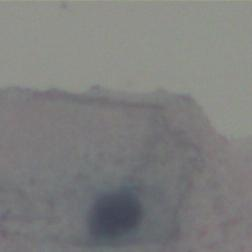

malignant: 0.6694158315658569


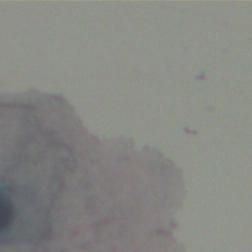

malignant: 0.7678568959236145


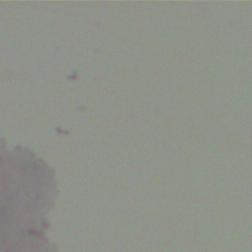

malignant: 0.7611283659934998


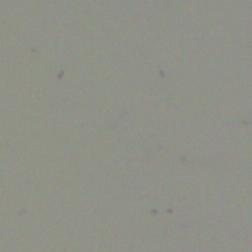

malignant: 0.8387271761894226


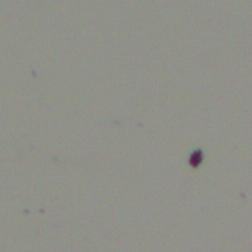

normal: 0.7192042469978333


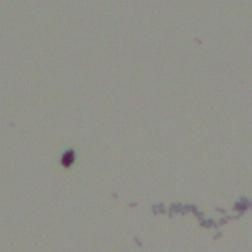

normal: 0.8123193383216858


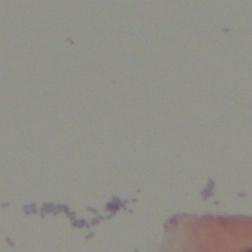

normal: 0.9043529629707336


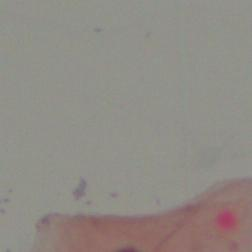

normal: 0.7241146564483643


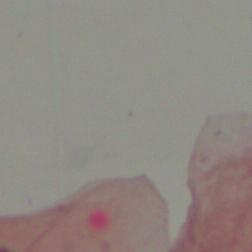

normal: 0.8612062335014343


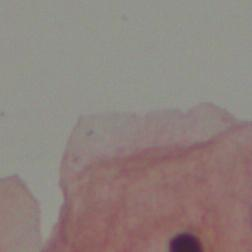

normal: 0.919287919998169


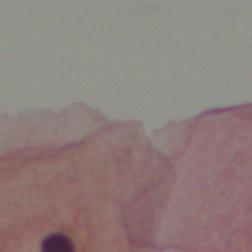

normal: 0.9049858450889587


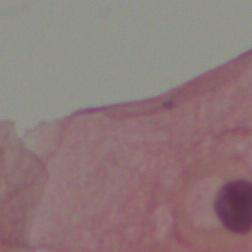

normal: 0.922754168510437


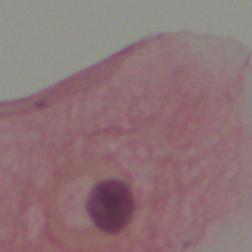

normal: 0.9749743342399597


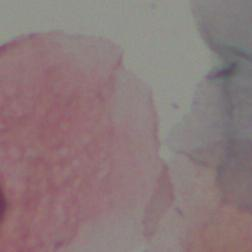

normal: 0.9537615776062012


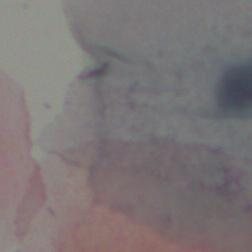

normal: 0.9445474147796631


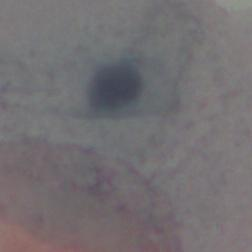

malignant: 0.6973116397857666


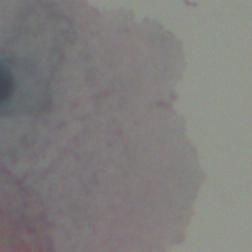

malignant: 0.7424959540367126


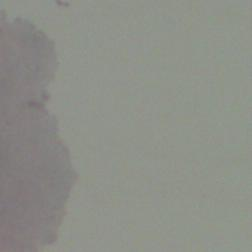

malignant: 0.5969436764717102


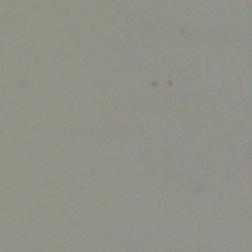

normal: 0.906087338924408


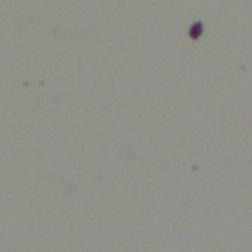

normal: 0.8269885778427124


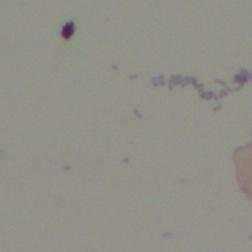

normal: 0.5430037975311279


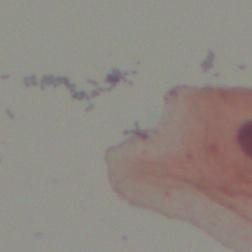

malignant: 0.6060130000114441


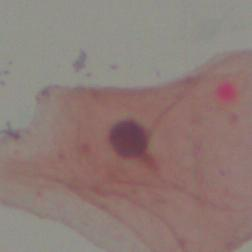

normal: 0.6898843050003052


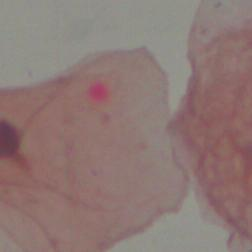

malignant: 0.733684241771698


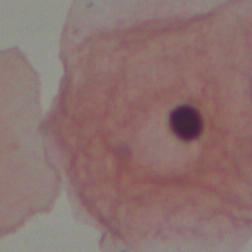

normal: 0.49371129274368286


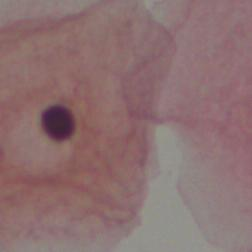

normal: 0.9801651239395142


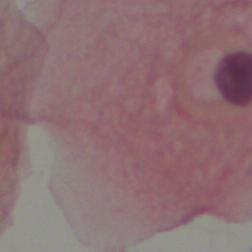

malignant: 0.8013284206390381


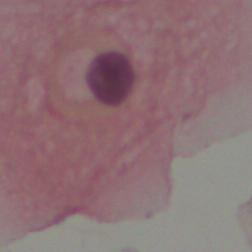

normal: 0.987564742565155


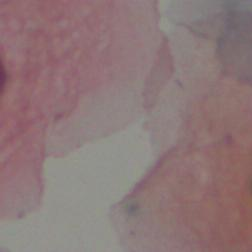

malignant: 0.8736545443534851


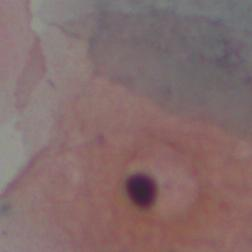

malignant: 0.7755856513977051


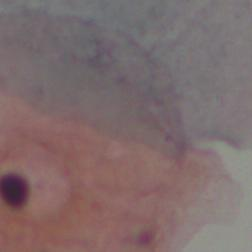

malignant: 0.6749032735824585


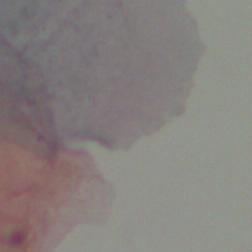

malignant: 0.7223722338676453


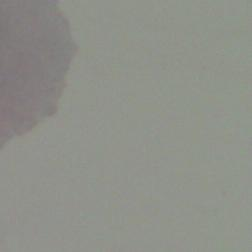

normal: 0.7683746218681335


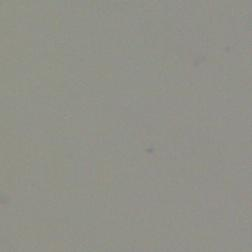

normal: 0.8893324732780457


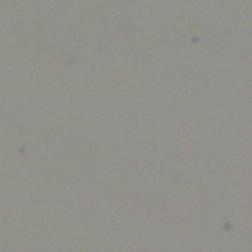

normal: 0.9181401133537292


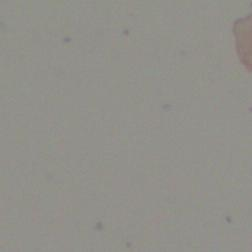

normal: 0.836629331111908


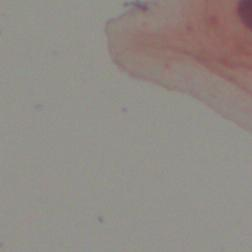

malignant: 0.6107351779937744


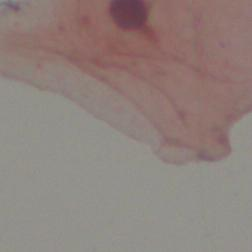

malignant: 0.5397399067878723


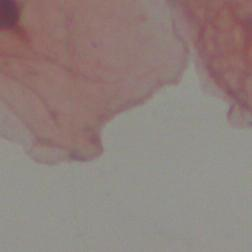

normal: 0.8685894012451172


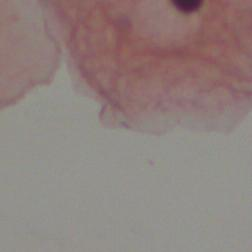

normal: 0.8315363526344299


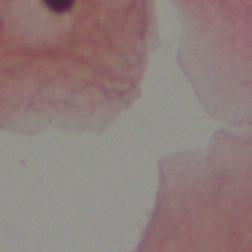

normal: 0.7412682771682739


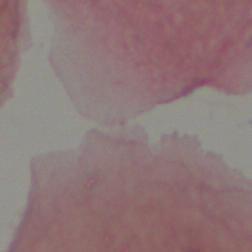

normal: 0.9635494947433472


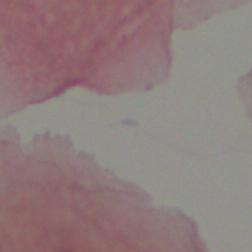

normal: 0.7356752157211304


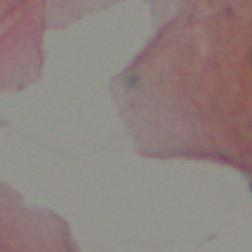

malignant: 0.9978036284446716


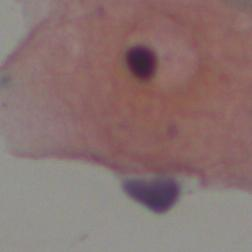

malignant: 0.8202889561653137


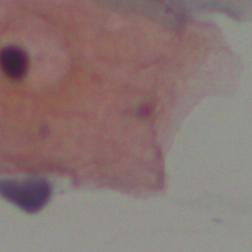

normal: 0.7905523777008057


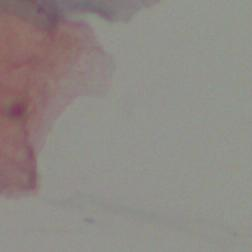

malignant: 0.7585771679878235


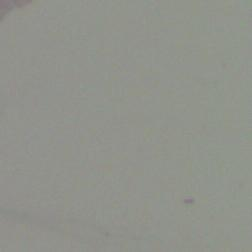

normal: 0.8664163947105408


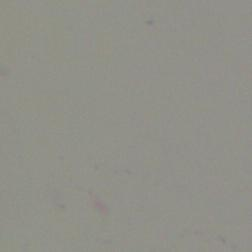

normal: 0.9468495845794678


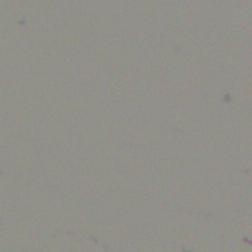

normal: 0.9674183130264282


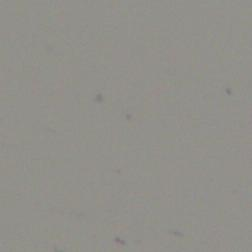

normal: 0.9617282152175903


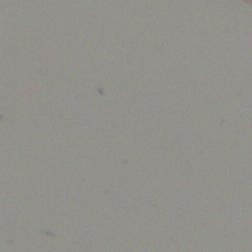

normal: 0.9813098907470703


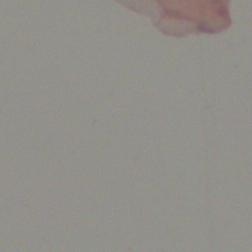

normal: 0.9674719572067261


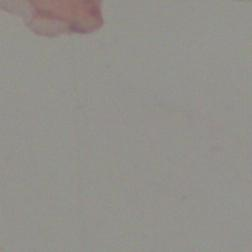

normal: 0.9574263691902161


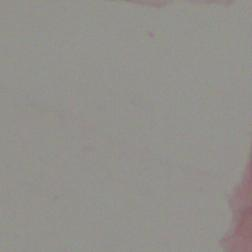

normal: 0.9828435182571411


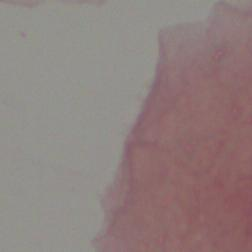

normal: 0.9927158951759338


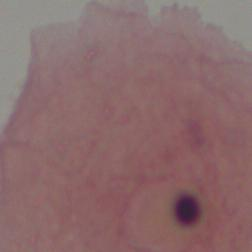

normal: 0.8819754719734192


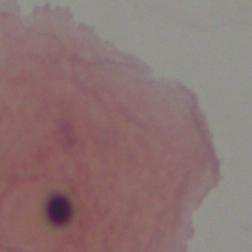

normal: 0.9773496985435486


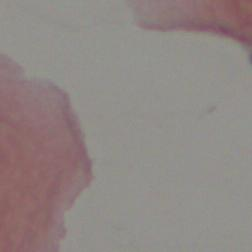

malignant: 0.7883954048156738


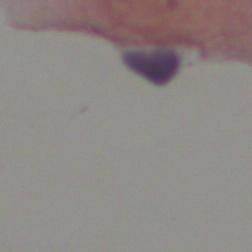

normal: 0.7951752543449402


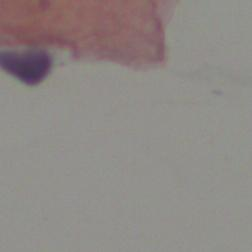

normal: 0.9367543458938599


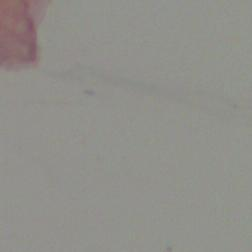

malignant: 0.7496379017829895


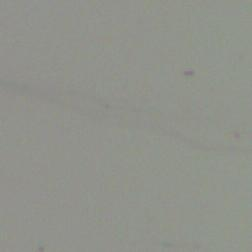

normal: 0.8622704744338989


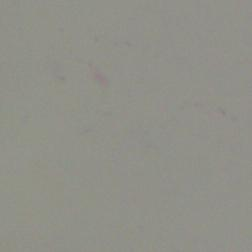

normal: 0.9463619589805603


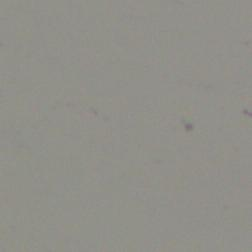

normal: 0.9721344113349915


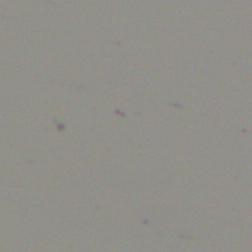

normal: 0.9748982787132263


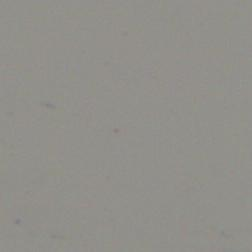

normal: 0.9718172550201416


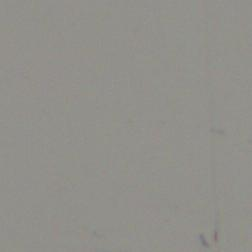

normal: 0.9857747554779053


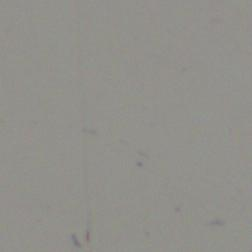

normal: 0.9881854057312012


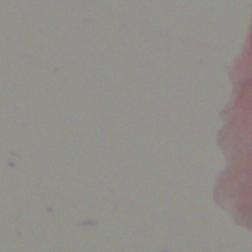

normal: 0.9872437119483948


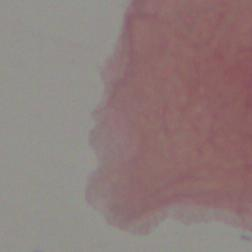

normal: 0.83775395154953


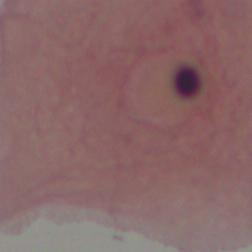

malignant: 0.6781430244445801


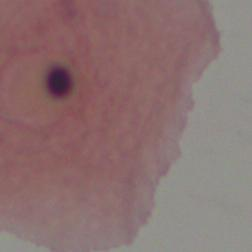

normal: 0.9895212650299072


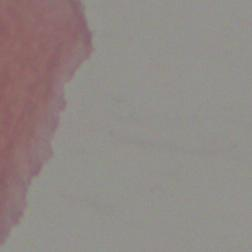

normal: 0.9931027889251709


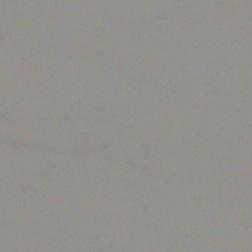

normal: 0.9897381663322449


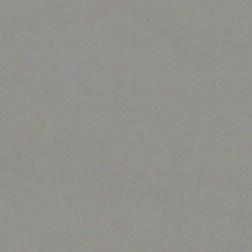

normal: 0.9587646722793579


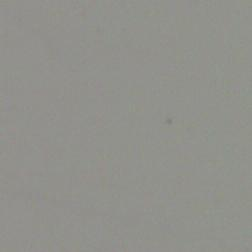

malignant: 0.7018114924430847


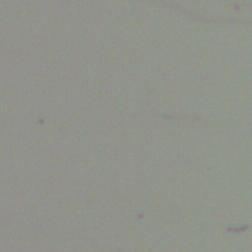

normal: 0.6328123807907104


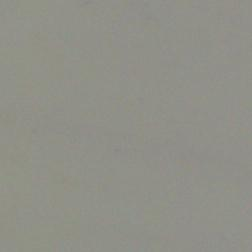

normal: 0.9420090913772583


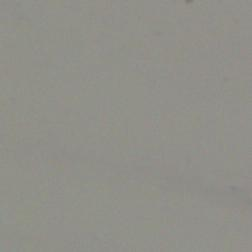

normal: 0.9693450331687927


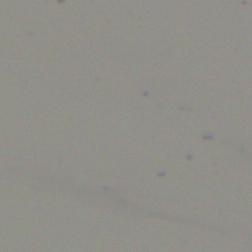

normal: 0.9804074168205261


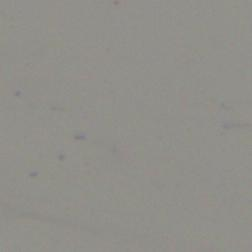

normal: 0.9631354212760925


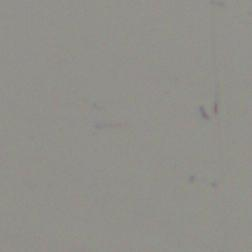

normal: 0.9705304503440857


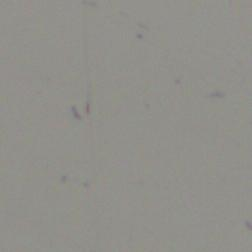

normal: 0.9724637866020203


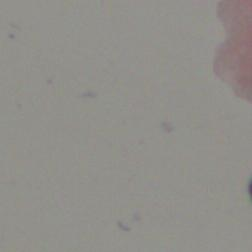

normal: 0.8475539088249207


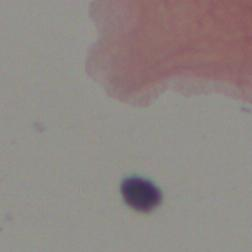

normal: 0.8034419417381287


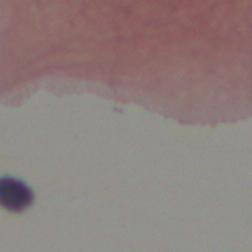

normal: 0.8602930307388306


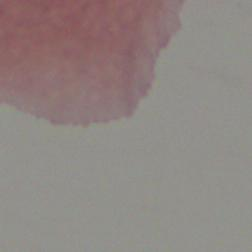

normal: 0.9879470467567444


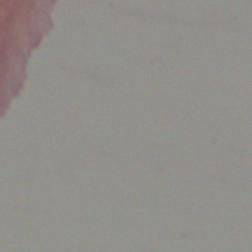

normal: 0.9914803504943848


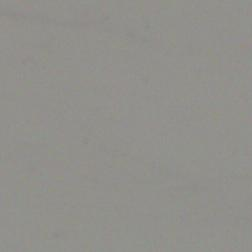

normal: 0.9825106263160706


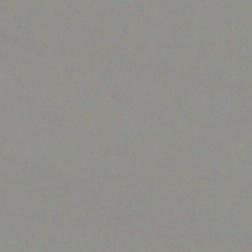

normal: 0.9565685987472534


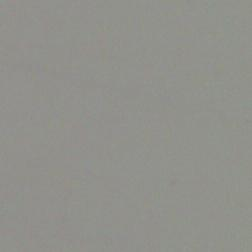

malignant: 0.7389327883720398


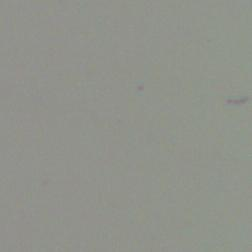

malignant: 0.6943389773368835


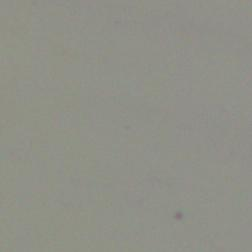

normal: 0.9271338582038879


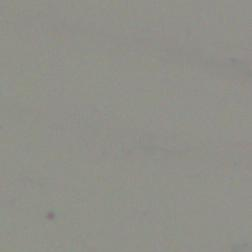

normal: 0.9639379382133484


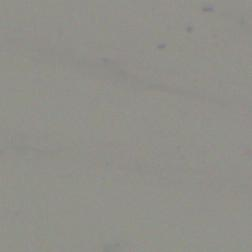

normal: 0.9723438620567322


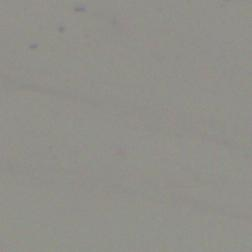

normal: 0.9637951850891113


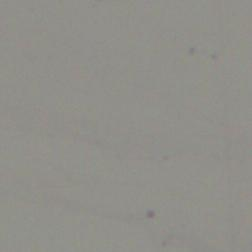

normal: 0.9730383157730103


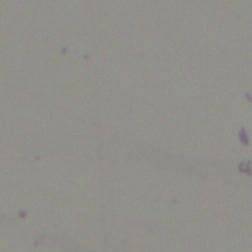

normal: 0.9658911228179932


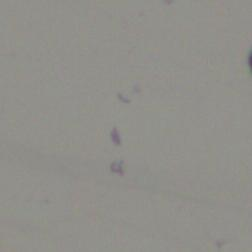

normal: 0.6915391087532043


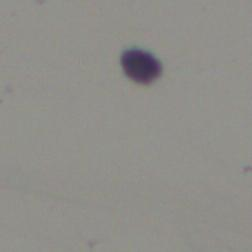

normal: 0.9323272705078125


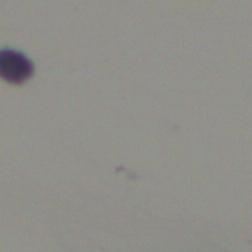

normal: 0.9762321710586548


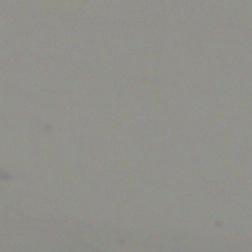

normal: 0.981600284576416


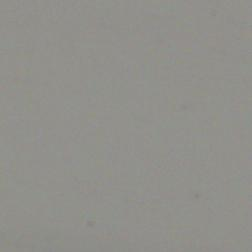

normal: 0.983363151550293


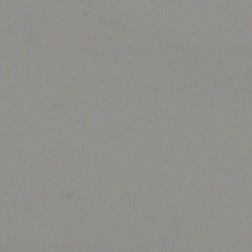

normal: 0.9782254695892334


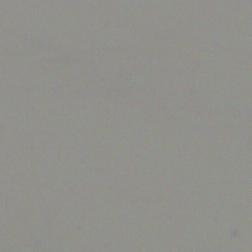

normal: 0.9608374834060669


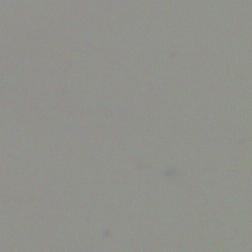

malignant: 0.7815440893173218


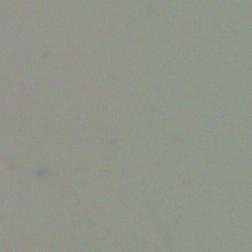

malignant: 0.8053023219108582


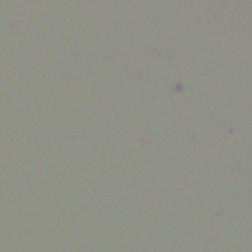

normal: 0.7032681703567505


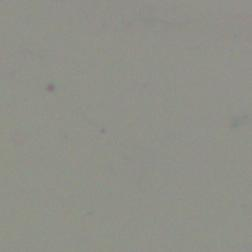

normal: 0.8938710689544678


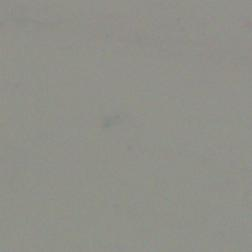

normal: 0.9658487439155579


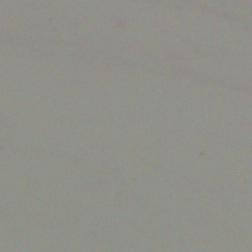

normal: 0.9678791761398315


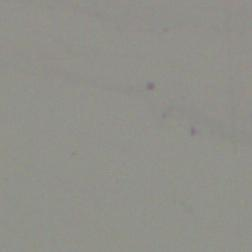

normal: 0.976284921169281


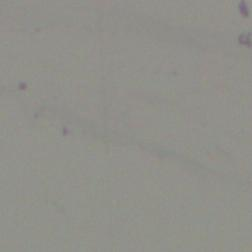

normal: 0.9602511525154114


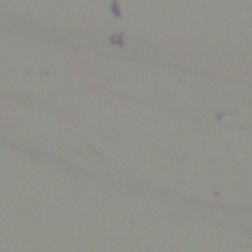

normal: 0.9722582101821899


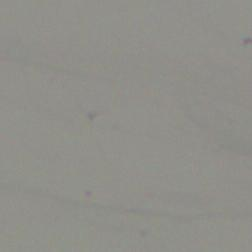

normal: 0.9678099751472473


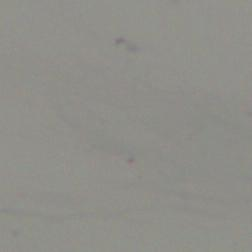

normal: 0.9790217876434326


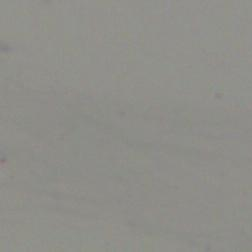

normal: 0.9817304611206055


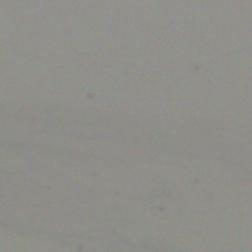

normal: 0.9826814532279968


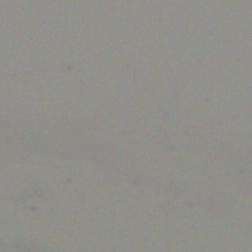

normal: 0.969417929649353


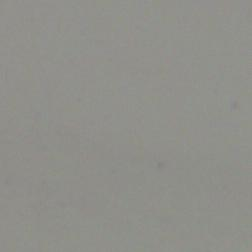

normal: 0.8891462683677673


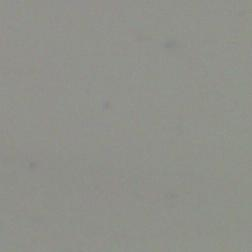

malignant: 0.8064067959785461


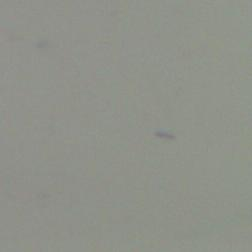

malignant: 0.7415786385536194


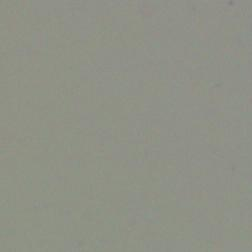

malignant: 0.8178843855857849


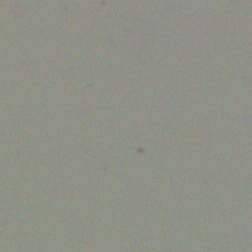

malignant: 0.8185557126998901


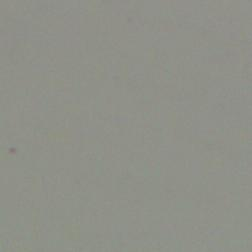

malignant: 0.7389020323753357


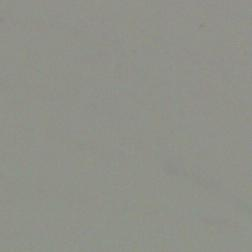

malignant: 0.4796355068683624


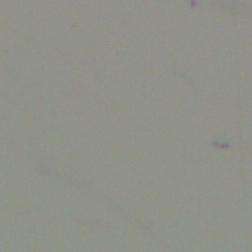

normal: 0.5210983157157898


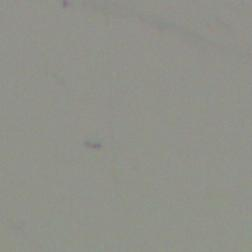

normal: 0.6720630526542664


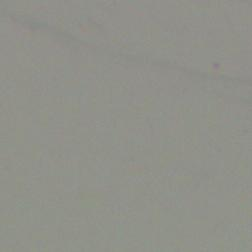

normal: 0.7204015254974365


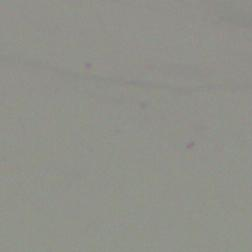

normal: 0.9293277859687805


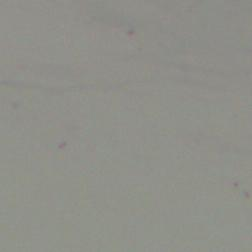

normal: 0.9539977312088013


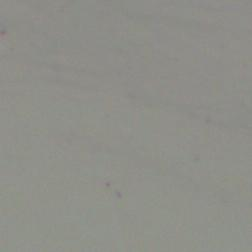

normal: 0.9937893748283386


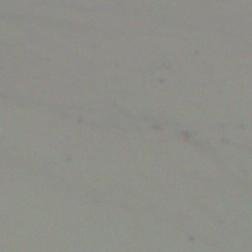

normal: 0.9931768178939819


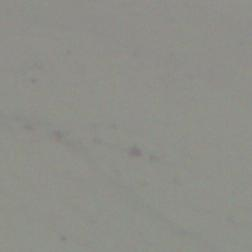

normal: 0.9780896902084351


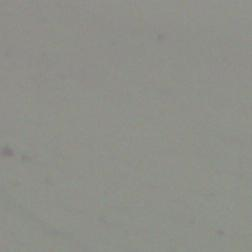

malignant: 0.7487672567367554


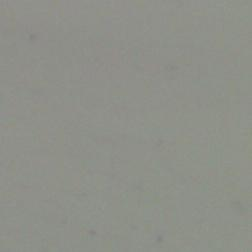

malignant: 0.7719770073890686


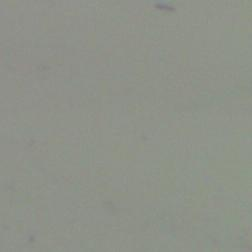

malignant: 0.7169649600982666


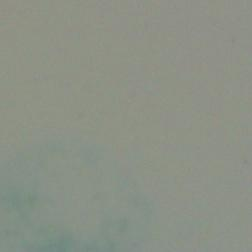

malignant: 0.7178099751472473


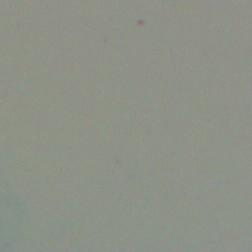

malignant: 0.7861768007278442


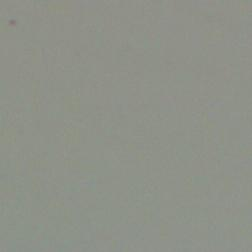

malignant: 0.8029851317405701


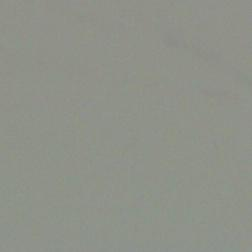

malignant: 0.8185182213783264


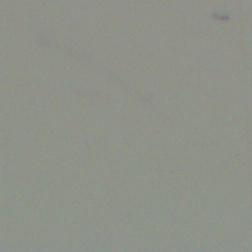

malignant: 0.808027446269989


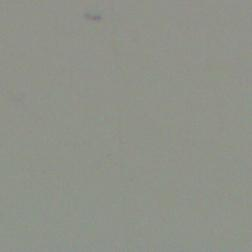

malignant: 0.8167428374290466


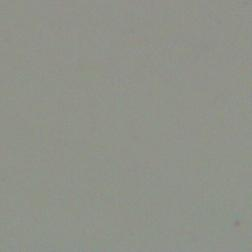

malignant: 0.8165966272354126


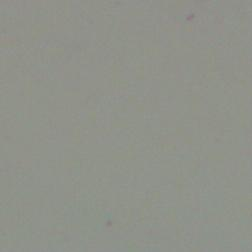

malignant: 0.8212138414382935


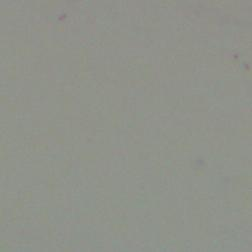

malignant: 0.79278165102005


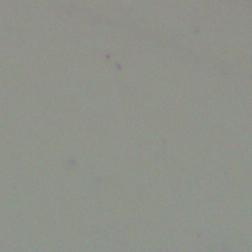

malignant: 0.6261683702468872


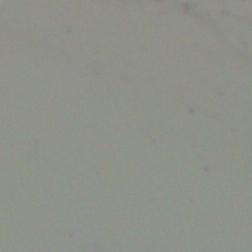

malignant: 0.5794238448143005


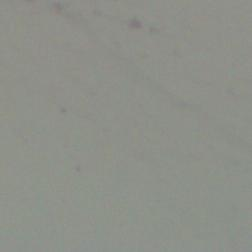

malignant: 0.7078593969345093


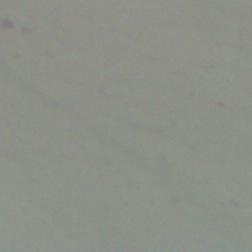

malignant: 0.8125205636024475


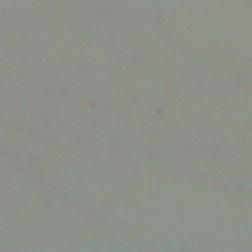

malignant: 0.7263911366462708


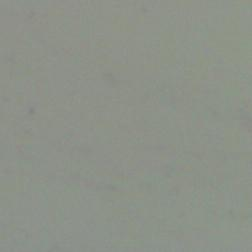

In [37]:

input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(3)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)